# *Challenge 1*: A **kernel** methods / **DL** pipeline for the FashionMNIST dataset

Advanced Topics in Machine Learning -- Fall 2023, UniTS

<a target="_blank" href="https://colab.research.google.com/github/ganselmif/adv-ml-units/blob/main/notebooks/AdvML_Challenge_1.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>


In [2]:
## Import Libraries
import numpy as np

from tqdm.auto import trange

import torch as th
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch.utils.data import DataLoader, SubsetRandomSampler, TensorDataset
import torch.optim as optim

from torchvision import datasets, transforms


import matplotlib.pyplot as plt

from sklearn.decomposition import PCA, KernelPCA

from sklearn.metrics import adjusted_rand_score, accuracy_score
from sklearn.model_selection import train_test_split

from sklearn.cluster import KMeans, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.svm import SVC

# Used to measure time
import time

In [3]:
## Import train and test dataset, scale them and convert them to data loaders

BATCH_SIZE = 64


train_dataset = datasets.FashionMNIST(
    root="./data",
    train=True,
    transform= transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(0, 1)]),
    download=True
)

test_dataset = datasets.FashionMNIST(
    root="./data",
    train=False,
    transform= transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(0, 1)]),
    download=True
)

train_loader = DataLoader(dataset = train_dataset,
                          batch_size = BATCH_SIZE,
                          shuffle = False)

test_loader = DataLoader(dataset = test_dataset,
                          batch_size = BATCH_SIZE,
                          shuffle = False)

In [4]:
## Randomly select some images from the training and test dataset

subset_size = 10000

## set a seed for randperm
th.manual_seed(42)

idx = th.randperm(len(train_dataset))[:subset_size]

sampler = SubsetRandomSampler(idx)

train_subset_loader = DataLoader(train_dataset, sampler=sampler)

idx = th.randperm(len(test_dataset))[:subset_size]

sampler = SubsetRandomSampler(idx)

test_subset_loader = DataLoader(train_dataset, sampler=sampler)

del(idx)
del(sampler)

In [5]:
## Convert the images and their labels to numpy arrays and reshape them to vectors

labels_train = []
train_subset = []
for batch in train_subset_loader:
    data, labels = batch
    
    train_subset.append(data.numpy().reshape(1, -1))
    labels_train.append(labels.numpy())

train_subset_scaled = np.array(train_subset).reshape(subset_size, -1)
labels_train = np.array(labels_train)

In [ ]:
# test_subset = []
# labels_test = []

# for batch in test_subset_loader:
#     data, labels = batch
    
#     test_subset.append(data.numpy().reshape(1, -1))
#     labels_test.append(labels.numpy())

# test_subset_scaled = np.array(test_subset).reshape(subset_size, -1)
# labels_test = np.array(labels_test)

In [6]:
# Creating dictionary of labels for better understanding
description = {0: "T-shirt/top", 
               1: "Trouser", 
               2: "Pullover", 
               3: "Dress", 
               4: "Coat", 
               5: "Sandal", 
               6: "Shirt", 
               7: "Sneaker", 
               8: "Bag", 
               9: "Ankle boot"}

ticks = list(description.keys())
tick_labels = list(description.values())

In [ ]:
## Defining functions to save and load data from pickle files

# def save_data(data, filename):
#     if not os.path.exists(filename):
#         with open(filename, "wb") as f:
#             pkl.dump(data, f)

# def load_data(filename):
#     if os.path.exists(filename):
#         with open(filename, "rb") as f:
#             data = pkl.load(f)
#     return data

## Exercise 1

In [7]:
# Choose the color map for the plots
cmap = plt.get_cmap('viridis', 10)

In [ ]:
## Perform linear PCA

model = PCA(n_components = 3)
data_pca_linear = model.fit_transform(train_subset_scaled)

del(model)

In [ ]:
# Plot the first two principal components

fig = plt.figure(figsize=(6, 6))
p = plt.scatter(data_pca_linear[:, 0], data_pca_linear[:, 1], c = labels_train, marker='.', cmap = cmap)

plt.xlabel('Principal Component 1', fontsize=11)
plt.ylabel('Principal Component 2', fontsize=11)


# Uncomment to plot the colorbar
# cb = plt.colorbar(p)
# cb.set_ticks(ticks)
# cb.set_ticklabels(tick_labels)
# cb.ax.set_title('Class', fontsize=11)
# del(cb)

# plt.savefig("Report/pca_linear_2comps.png")

In [ ]:
# Plot the first two principal components

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

for i in range(3):
    p = ax.scatter(data_pca_linear[:, 0], data_pca_linear[:, 1], data_pca_linear[:, 2], c = labels_train, marker='.', cmap=cmap)
ax.view_init(elev=30, azim=30)


# Uncomment to show colorbar
cb = plt.colorbar(p, ax = ax, shrink = 1, aspect = 20)
cb.set_ticks(ticks)
cb.set_ticklabels(tick_labels, fontsize = 11)
# cb.ax.set_title('Class', fontsize=11)
del(cb)

del(fig)
del(ax)
del(p)


# plt.savefig("Report/pca_linear_3comps.png")

#### Comment
The data does not seem to be well separated, so finding the right hyperplane for classification will be hard.

### 1.2: Perform kernel PCA

In [ ]:
# Perform kernel pca using the RBF kernel
    
kernel_pca = KernelPCA(kernel="rbf", n_components = 3)
data_pca_rbf = kernel_pca.fit_transform(train_subset_scaled)

In [ ]:
# Plot the first 2 principal components

fig = plt.figure(figsize=(6, 6))
p = plt.scatter(data_pca_rbf[:, 0], data_pca_rbf[:, 1], c = labels_train, marker='.', cmap=cmap)

plt.xlabel('Principal Component 1', fontsize=11)
plt.ylabel('Principal Component 2', fontsize=11)

# cb = plt.colorbar(p)
# cb.ax.set_title('Class', fontsize=11)
# del(cb)

del(p)
del(fig)
# plt.savefig("Report/pca_rbf_2comps.png")

In [ ]:
# Plot the first 3 principal components

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

for i in range(3):
    p = ax.scatter(data_pca_rbf[:, 0], data_pca_rbf[:, 1], data_pca_rbf[:, 2], c = labels_train, marker='.', cmap=cmap)

cb = plt.colorbar(p, ax = ax, shrink = 1, aspect = 20)
cb.set_ticks(ticks)
cb.set_ticklabels(tick_labels, fontsize = 11)
del(cb)

ax.view_init(elev=30, azim=30)

del(fig)
del(ax)
del(p)

# plt.savefig("Report/pca_rbf_3comps.png")

### Perform parameter tuning

In [ ]:
kernel_pca = KernelPCA(kernel = "rbf", n_components = 3, gamma = 5 / 784)
data_pca_rbf = kernel_pca.fit_transform(train_subset_scaled)

plt.scatter(data_pca_rbf[:, 0], data_pca_rbf[:, 1], c = labels_train, marker='.', cmap=cmap)

In [ ]:
# Perform kernel pca using the RBF kernel, tune gamma to separate clusters
    
gamma = np.array([(1/10)*(1/784), 1/784, 10 * (1/784)])

data_pca_rbf = np.ndarray((10000, 3, len(gamma)))

for i in range(len(gamma)):
    kernel_pca = KernelPCA(kernel = "rbf", n_components = 3, gamma = gamma[i])
    data_pca_rbf[:, :, i] = kernel_pca.fit_transform(train_subset_scaled)

In [ ]:
# scatterplot for different gammas

gammas = ["$\\frac{1}{5} * \\frac{1}{784}$", "$\\frac{1}{784}$", "$5 * \\frac{1}{784}$"]
fig, axs = plt.subplots(1, 3, figsize=(20, 4))

for i, ax in enumerate(axs.flat):
    p = ax.scatter(data_pca_rbf[:, 0, i], data_pca_rbf[:, 1, i], c = labels_train, marker='.', cmap=cmap)
    ax.set_title('Gamma = ' + gammas[i])

# cb = plt.colorbar(p)
# cb.ax.set_title('Class', fontsize=11)

In [ ]:
## Choose the range of the parameter gamma
gammas = np.arange(1/784 - 5 * (1/784) * (1/10), 1/784 + 5 * (1/784) * (1/10), (1/784) * (1/10))

## Extract eigenvalues
n_components = 3
eigenvalues_rbf = np.empty((len(gammas), n_components))

for i in range(len(gammas)):
    kernel_pca = KernelPCA(kernel="rbf", n_components = n_components, gamma = gammas[i])
    eigenvalues_rbf[i] = kernel_pca.fit(train_subset_scaled).eigenvalues_



fig, axs = plt.subplots(2, 5, figsize=(30, 10))
# Create 10 random plots
for i, ax in enumerate(axs.flat):
    x = np.arange(1, len(eigenvalues_rbf[i, :]) + 1, 1)
    # Plot the data on the corresponding axis
    ax.bar(x, eigenvalues_rbf[i, :])
    ax.set_ylim(0, 1000)
    # ax.set_xlabel('Component')
    # ax.set_ylabel('Eigenvalue')
    ax.set_title('Gamma = ' + str(gammas[i]))

### 1.3 Perform kPCA using another kernel

In [ ]:
# Try kernel poly

kernel_pca = KernelPCA(kernel = "poly", n_components = 3)

data_pca_poly = kernel_pca.fit_transform(train_subset_scaled)

In [ ]:
# Plot the first 2 principal components

fig = plt.figure(figsize=(6, 6))
p = plt.scatter(data_pca_poly[:, 0], data_pca_poly[:, 1], c = labels_train, marker='.', cmap = cmap)

# cb = plt.colorbar(p)
# cb.ax.set_title('Class', fontsize=11)
# del(cb)

plt.xlabel('Principal Component 1', fontsize=11)
plt.ylabel('Principal Component 2', fontsize=11)

# plt.savefig("Report/pca_poly_2comps.png")

In [ ]:
# Plot the first 3 principal components

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

for i in range(3):
    p = ax.scatter(data_pca_poly[:, 0], data_pca_poly[:, 1], data_pca_poly[:, 2], c = labels_train, marker='.', cmap=cmap)

cb = plt.colorbar(p, ax = ax, shrink = 1, aspect = 20)
cb.set_ticks(ticks)
cb.set_ticklabels(tick_labels, fontsize = 11)

ax.view_init(elev=30, azim=30)

# plt.savefig("Report/pca_poly_3comps.png")

In [ ]:
# Try kernel sigmoid
kernel_pca = KernelPCA(kernel="sigmoid", n_components = 10)

data_pca_sigmoid = kernel_pca.fit_transform(train_subset_scaled)

eigenvalues_sigmoid = kernel_pca.eigenvalues_

In [ ]:
# Plot the first 2 principal components

fig = plt.figure(figsize=(6, 6))
p = plt.scatter(data_pca_sigmoid[:, 0], data_pca_sigmoid[:, 1], c = labels_train, marker='.', cmap = cmap)

# cb = plt.colorbar(p)
# cb.ax.set_title('Class', fontsize=11)
# del(cb)

plt.xlabel('Principal Component 1', fontsize=11)
plt.ylabel('Principal Component 2', fontsize=11)

# plt.savefig("Report/pca_sigmoid_2comps.png")

In [ ]:
# Plot the first 3 principal components

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

for i in range(3):
    p = ax.scatter(data_pca_sigmoid[:, 0], data_pca_sigmoid[:, 1], data_pca_sigmoid[:, 2], c = labels_train, marker='.', cmap = cmap)

cb = plt.colorbar(p, ax = ax, shrink = 1, aspect = 20)
cb.set_ticks(ticks)
cb.set_ticklabels(tick_labels, fontsize = 11)

ax.view_init(elev=30, azim=30)

# plt.savefig("Report/pca_sigmoid_3comps.png")

In [ ]:
# Measure separation of the clusters using the Davies-Bouldin score
# The lower the better

# DB_score = []

# DB_score.append(davies_bouldin_score(data_pca_linear, labels_train.reshape(-1)))
# DB_score.append(davies_bouldin_score(data_pca_rbf, labels_train.reshape(-1)))
# DB_score.append(davies_bouldin_score(data_pca_poly, labels_train.reshape(-1)))
# DB_score.append(davies_bouldin_score(data_pca_sigmoid, labels_train.reshape(-1)))

# print(f"DB score: linear: {DB_score[0]:.4f} | rbf: {DB_score[1]:.4f} | poly: {DB_score[2]:.4f} | sigmoid: {DB_score[3]:.4f}")

In [ ]:
del(p)
del(axs)
del(ax)
del(fig)
del(cb)

## Exercise 2

In [ ]:
# Perform clustering with different techniques

labels_Kmeans = KMeans(n_clusters = 10, n_init=10).fit(data_pca_sigmoid).labels_

labels_Spectral = SpectralClustering(n_clusters = 10, affinity='nearest_neighbors').fit(data_pca_sigmoid).labels_

labels_Gaussian = GaussianMixture(n_components = 10).fit(data_pca_sigmoid).predict(data_pca_sigmoid)

labels = np.array([labels_train.reshape(subset_size), labels_Kmeans, labels_Spectral, labels_Gaussian])

In [ ]:
# Plot the results and compare them with the original clustering

fig, axs = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)

title_names = ["Original", "K Means", "Spectral Clustering", "Gaussian Mixture"]

for ax, i in zip(axs.flat, range(4)):
    ax.scatter(data_pca_sigmoid[:, 0], data_pca_sigmoid[:, 1], c = labels[i, :], marker='.')
    ax.set_title(title_names[i])  
# plt.savefig("Report/unsupervised_clustering.png")

In [ ]:
# Calculate Adjusted Rand Index

ARI = np.empty(3)

for i in range(3):
    ARI[i] = adjusted_rand_score(labels[0, :], labels[i + 1, :])
    print(f"Adjusted Rand Index for {title_names[i + 1]}: {ARI[i]:.4f}")


In [ ]:
# Measure separation of the clusters using the Davies-Bouldin score
# The lower the better

# DB_score = []

# DB_score.append(davies_bouldin_score(data_pca_sigmoid, labels[0, :].reshape(-1)))
# DB_score.append(davies_bouldin_score(data_pca_sigmoid, labels[1, :].reshape(-1)))
# DB_score.append(davies_bouldin_score(data_pca_sigmoid, labels[2, :].reshape(-1)))
# DB_score.append(davies_bouldin_score(data_pca_sigmoid, labels[3, :].reshape(-1)))

# print(f"DB score: original: {DB_score[0]:.4f} | KMeans: {DB_score[1]:.4f} | Spectral: {DB_score[2]:.4f} | Gaussian: {DB_score[3]:.4f}")

#### a
As we can see, label assignment performed poorly. This, probably, because the clusters are very close to each other and not clearly separated.

#### b
As we can see from the plot below, there is a clear elbow on the third component. This suggests that 10 does not reflect the actual knee point of the spectrum of the principal components.

In [ ]:
# Plot the eigenvalues obtained with the sigmoid method

plt.plot(np.arange(1, len(eigenvalues_sigmoid) + 1, 1), eigenvalues_sigmoid)

plt.xticks(np.arange(1, 11, 1))

plt.xlabel('Component')
plt.ylabel('Eigenvalue')

# plt.savefig("Report/eigenvalues_sigmoid.png")

In [ ]:
del(ARI)
del(eigenvalues_sigmoid)
del(labels_Kmeans)
del(labels_Gaussian)
del(ax)
del(axs)
del(labels)

## Exercise 3

In [44]:
# Split the dataset into training and test set

x_train, x_test, y_train, y_test = train_test_split(train_subset_scaled, labels_Spectral, test_size=0.3, random_state=42)

NameError: name 'labels_Spectral' is not defined

#### 3.1: kernel SVM with different kernels

In [ ]:
# Linear kernel

classifier = SVC(kernel = "linear").fit(x_train, y_train.reshape(len(y_train)))

label_predict_SVC_linear = classifier.predict(x_test)

acc_linear = accuracy_score(y_test, label_predict_SVC_linear)

In [ ]:
# RBF kernel

classifier = SVC(kernel = "rbf").fit(x_train, y_train.reshape(len(y_train)))

label_predict_SVC_rbf = classifier.predict(x_test)

acc_rbf = accuracy_score(y_test, label_predict_SVC_rbf)

In [ ]:
# Polynomial kernel

classifier = SVC(kernel = "poly").fit(x_train, y_train.reshape(len(y_train)))

label_predict_SVC_poly = classifier.predict(x_test)

acc_poly = accuracy_score(y_test, label_predict_SVC_rbf)

In [ ]:
# Sigmoid kernel

classifier = SVC(kernel = "sigmoid").fit(x_train, y_train.reshape(len(y_train)))

label_predict_SVC_sigmoid = classifier.predict(x_test)

acc_sigmoid = accuracy_score(y_test, label_predict_SVC_sigmoid)

In [ ]:
print(f"Accuracy: linear: {acc_linear:.2f} | rbf: {acc_rbf:.2f} | poly: {acc_poly:2f} | sigmoid: {acc_sigmoid:.2f}")

In [ ]:
labels_SVC_unsupervised = np.concatenate((y_test.reshape(len(y_test), 1),
                                            label_predict_SVC_linear.reshape(len(y_test), 1),
                                            label_predict_SVC_rbf.reshape(len(y_test), 1),
                                            label_predict_SVC_poly.reshape(len(y_test), 1),
                                            label_predict_SVC_sigmoid.reshape(len(y_test), 1)), axis = 1)

In [ ]:
model = KernelPCA(kernel = "sigmoid", n_components = 3).fit_transform(x_test)

fig, axs = plt.subplots(1, 5, figsize=(15, 3), sharex=True, sharey=True)

titles = ["Original", "Linear", "RBF", "Polynomial", "Sigmoid"]

i = 0
for ax in axs:
    ax.scatter(model[:, 0], model[:, 1], c = labels_SVC_unsupervised[:, i], cmap = 'viridis', marker='.')
    ax.title.set_text(titles[i])
    i += 1

#### 3.2: Fully Connected NN

In [42]:
## Pass data to tensors

data_train = TensorDataset(Tensor(x_train.reshape(-1, 1, 28, 28)), th.tensor(y_train, dtype = th.long))
data_train_loader = DataLoader(dataset = data_train, batch_size = BATCH_SIZE, shuffle = False)



data_test = TensorDataset(Tensor(x_test.reshape(-1, 1, 28, 28)), th.tensor(y_test, dtype = th.long))
data_test_loader = DataLoader(dataset = data_test, batch_size = BATCH_SIZE, shuffle = False)

In [ ]:
# Decide if you want to train muoltiple models with different hyperparameters
train_multiple_models = True

In [26]:
# Define some functions needed to calculate the accuracy

def get_batch_accuracy(logit, target):
    corrects = (th.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects / target.size(0)
    return accuracy.item()


def get_test_stats(model, criterion, test_loader, device):
    test_acc, test_loss = 0.0, 0.0
    for i, (images, labels) in enumerate(test_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        test_loss += criterion(outputs, labels).item()
        test_acc += get_batch_accuracy(outputs, labels)
        return test_loss, test_acc

In [27]:
# Define function used to train the model

def train_model(epochs, train_loader, criterion, optimizer, device, model):
    _batch_losses = []
    
    _model = model
    for _ in trange(epochs):
        _model = _model.train()

        # Actual (batch-wise) training step
        for _, (_images, _labels) in enumerate(train_loader):
            _images = _images.to(device)
            _labels = _labels.to(device)

            _logits = _model(_images)
            _loss = criterion(_logits, _labels)
            _batch_losses.append(_loss.item())  # Store the loss for plotting, per batch

            optimizer.zero_grad()
            _loss.backward()
            optimizer.step()
    
    return _model

In [28]:
## Define function used to get labels
def get_predicted_labels(model, test_data, device):
    test_data_tensor = th.tensor(test_data.reshape(-1, 1, 28, 28))

    model = model.eval()

    labels = []
    with th.no_grad():
        for i in range(test_data_tensor.shape[0]):
            data = test_data_tensor[i].reshape(1, 1, 28, 28)
            pred = model(data.to(device))
            labels.append(th.argmax(pred).item())
            
    return np.array(labels)

In [ ]:
# Define the Fully Connected Neural Network

# class FullyConnectedNN_1layer(nn.Module):
#     def __init__(self, image_dim, n_classes):
        
#         super(FullyConnectedNN_1layer, self).__init__()
        
#         self.fc1 = nn.Linear(in_features = image_dim,
#                             out_features = n_classes)
    
#     def forward(self, x):
#         x = x.flatten(start_dim = 1)
#         x = self.fc1(x)
#         # x = F.relu(x)
#         x = F.log_softmax(x, dim = 1)
#         return x

In [22]:
# Choose device
device = th.device("cuda" if th.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [23]:
learning_rate_FCNN = 0.01

In [ ]:
# # Train the model and calculate accuracy on the test set

# if train_multiple_models:
#     # Choose for which epochs to train the model
#     epochs = np.arange(1, 21, 1)

#     # Store the accuracies and predicted labels in two arrays
#     trained_acc_FC_1l = []
#     labels_FC_1l = np.ndarray((3000, len(epochs)))
    
#     # Choose the loss  
#     criterion = nn.CrossEntropyLoss()

#     # Create a vectors to store the training time (column 1) for each epoch (column 0)
#     times = np.ndarray((len(epochs), 2))

#     for i in epochs:
#         model = FullyConnectedNN_1layer(image_dim = 28 * 28, n_classes = 10).to(device)

#         optimizer = th.optim.SGD(model.parameters(), lr = learning_rate_FCNN)
        
#         model = model.eval()

#         untrained_loss, untrained_acc = get_test_stats(model, criterion, data_train_loader, device)


#         model = model.train()
        
#         # Keep track of how much time is required to train the model
#         start_time = time.time()
#         model = train_model(epochs = i,
#                             train_loader = data_train_loader,
#                             criterion = criterion,
#                             optimizer = optimizer,
#                             device = device,
#                             model = model)
#         end_time = time.time()
        
#         times[i - 1, 0] = i
#         times[i - 1, 1] = end_time - start_time
        
#         model = model.eval()
                
#         trained_loss, trained_acc = get_test_stats(model, criterion, data_test_loader, device)
#         trained_acc_FC_1l.append(trained_acc)
        
        
#         labels_FC_1l[:, i - 1] = get_predicted_labels(model = model, test_data = x_test, device = device)

#         print(f"Epochs: {i} | Accuracy: untrained: {untrained_acc:.4f} | Trained: {trained_acc:.4f} | Time: {times[i - 1, 1]:.2f} s")


In [ ]:
# # Plot the accuracy as a function of the number of epochs

# if train_multiple_models:
#     plt.plot(np.arange(1, len(trained_acc_FC_1l) + 1, 1), trained_acc_FC_1l)
#     plt.xticks(np.arange(1, len(trained_acc_FC_1l) + 1, 2))
#     plt.xlabel('Number of epochs')
#     plt.ylabel('Accuracy')
#     plt.ylim(50, 100)
#     plt.savefig("Report/ex3_FCNN1l_accuracy-epochs.png")

In [20]:
# Try with two layers

class FullyConnectedNN_2layer(nn.Module):
    def __init__(self, image_dim, n_classes, hidden_features):
        
        super(FullyConnectedNN_2layer, self).__init__()
        
        self.fc1 = nn.Linear(in_features = image_dim,
                            out_features = hidden_features)
        
        self.fc2 = nn.Linear(in_features = hidden_features,
                             out_features = n_classes)
    
    def forward(self, x):
        x = x.flatten(start_dim = 1)
        x = self.fc1(x)
        # x = F.relu(x)
        x = self.fc2(x)
        # x = F.relu(x)
        x = F.log_softmax(x, dim = 1)
        return x

In [24]:
leaning_rate_FCNN = 0.01
epochs_FCNN = 11

In [ ]:
# See how accuracy vary with the number of hidden neurons

if train_multiple_models:
    # Choose for which numbers of neurons to train the model
    neurons = np.arange(50, 10050, 1000)

    trained_acc_FC_2l_neurons = []
    labels_FC_2l = np.ndarray((len(x_test), len(neurons)))

    times = np.ndarray((len(neurons), 2))

    # Choose the loss
    criterion = nn.CrossEntropyLoss()

    for i in range(len(neurons)):
        model = FullyConnectedNN_2layer(image_dim = 28 * 28, n_classes = 10, hidden_features = neurons[i])
        
        model = model.to(device)
        print(f"Using device: {device}")

        optimizer = th.optim.SGD(model.parameters(), lr = leaning_rate_FCNN)
        

        model = model.eval()

        untrained_loss, untrained_acc = get_test_stats(model, criterion, data_train_loader, device)
            
        model = model.train()
        
        start_time = time.time()
        model = train_model(epochs = epochs_FCNN,
                            train_loader = data_train_loader,
                            criterion = criterion,
                            optimizer = optimizer,
                            device = device,
                            model = model)
        
        times[i, 0] = neurons[i]
        times[i, 1] = time.time() - start_time
        
                
        model = model.eval()

        trained_loss, trained_acc = get_test_stats(model, criterion, data_test_loader, device)
        trained_acc_FC_2l_neurons.append(trained_acc)
        
        print(f"Epochs: {i} | Accuracy: untrained: {untrained_acc:.4f} | Trained: {trained_acc:.4f} | Time: {times[i, 1]:.2f} s")
        
        model = model.eval()
        labels_FC_2l[:, i] = get_predicted_labels(test_data = x_test, device=device, model = model)

In [ ]:
hidden_size_FCNN = 50

In [ ]:
# Plot accuracy wrt number of neurons

if train_multiple_models:
    plt.plot(neurons, trained_acc_FC_2l_neurons)
    plt.ylim((50, 100))
    plt.xlabel("Number of hidden neurons")
    plt.ylabel("Accuracy")

    plt.savefig("Report/ex3_FCNN2l_accuracy-neurons.png")

In [ ]:
# Test how accuracy varies depending on the number of epochs

if train_multiple_models:
    # Define vector to keep all the accuracies, that we will plot
    trained_acc_FC_2l = []

    epochs = np.arange(1, 21, 1)
    # Define an array to keep all the predicted labels
    labels_FC_2l = np.ndarray((len(x_test), len(epochs)))

    # Choose loss
    criterion = nn.CrossEntropyLoss()

    times = np.ndarray((len(epochs), 2))


    for i in range(len(epochs)):
        model = FullyConnectedNN_2layer(image_dim = 28 * 28, n_classes = 10, hidden_features = 850)
        
        model = model.to(device)
        print(f"Using device: {device}")

        optimizer = th.optim.SGD(model.parameters(), lr = 0.01)
        

        model = model.eval()

        untrained_loss, untrained_acc = get_test_stats(model, criterion, data_train_loader, device)

        print(f"Untrained test loss: {untrained_loss:.4f}, accuracy: {untrained_acc:.2f}%")
        
        model = model.train()
        
        start_time = time.time()
        model = train_model(epochs = epochs[i],
                            train_loader = data_train_loader,
                            criterion = criterion,
                            optimizer = optimizer,
                            device = device,
                            model = model)
        
        times[i, 0] = epochs[i]
        times[i, 1] = time.time() - start_time
        
        model = model.eval()

        trained_loss, trained_acc = get_test_stats(model, criterion, data_test_loader, device)
        trained_acc_FC_2l.append(trained_acc)
        
        print(f"Epochs: {i} | Accuracy: untrained: {untrained_acc:.4f} | Trained: {trained_acc:.4f} | Time: {times[i, 1]:.2f} s")
        
        model = model.eval()
        labels_FC_2l[:, i] = get_predicted_labels(test_data = x_test, device=device, model = model)

In [ ]:
epochs_FCNN = 11

In [ ]:
# Plot the accuracy wrt the number of epochs used to train the model

if train_multiple_models:
    plt.plot(np.arange(1, 21, 1), trained_acc_FC_2l)
    plt.xticks(np.arange(1, 21, 2))
    plt.ylim((50, 100))
    plt.xlabel("Number of epochs")
    plt.ylabel("Accuracy")

    plt.savefig("Report/ex3_FCNN2l_accuracy-epochs.png")

In [ ]:
# Choose one model and a set of parameter to predict the labels

times = []
test_accuracies = []

for i in range(20):
    model = FullyConnectedNN_2layer(image_dim = 28 * 28, n_classes = 10, hidden_features = hidden_size_FCNN)

    model = model.to(device)

    optimizer = th.optim.SGD(model.parameters(), lr = learning_rate_FCNN)

    criterion = nn.CrossEntropyLoss()


    model = model.eval()

    untrained_loss, untrained_acc = get_test_stats(model, criterion, data_train_loader, device)

    model = model.train()

    start_time = time.time()
    model = train_model(epochs = epochs_FCNN,
                        train_loader = data_train_loader,
                        criterion = criterion,
                        optimizer = optimizer,
                        device = device,
                        model = model)

    elapsed_time = time.time() - start_time

    model = model.eval()

    trained_loss, trained_acc = get_test_stats(model, criterion, data_test_loader, device)

    print(f"Accuracy: untrained: {untrained_acc:.4f} | Trained: {trained_acc:.4f} | Time: {elapsed_time:.2f} s")
    times.append(elapsed_time)
    test_accuracies.append(trained_acc)

model = model.eval()
labels_FCNN = get_predicted_labels(test_data = x_test, device = device, model = model)


In [ ]:
print(f"Average time: {np.mean(times):.2f} s | Max time: {np.max(times):.2f} s | Min time: {np.min(times):.2f} s")
print(f"Average accuracy: {np.mean(test_accuracies):.2f}% | Max accuracy: {np.max(test_accuracies):.2f}% | Min accuracy: {np.min(test_accuracies):.2f}%")

#### 3.3: Convolutional Neural Network

In [ ]:
# class CNN_1layer(nn.Module):
#     def __init__(self, n_classes, kernel_size, input_size):
#         super(CNN_1layer, self).__init__()
        
#         self._n_classes = n_classes
        
#         self._padding = 0 # Default value
        
#         self._stride = 1 # Default value
        
#         self._stride_inv = 1 / self._stride
        
#         self._kernel = kernel_size
        
#         self._dimensions = input_size
        
 
#         self.conv1 = nn.Conv2d(in_channels=self._dimensions[1],
#                                out_channels = self._dimensions[1],
#                                kernel_size=self._kernel)
        
#         self.bn1 = nn.BatchNorm2d(self._dimensions[1])
        
#         self._dimensions = [self._dimensions[0],
#                             self._dimensions[1] ,
#                             (self._dimensions[2] - self._kernel + 2 * self._padding) * self._stride_inv + 1,
#                             (self._dimensions[3] - self._kernel + 2 * self._padding) * self._stride_inv + 1
#                             ]
        
            
#         self.pool = nn.MaxPool2d(kernel_size = 2, stride = self._stride)
        
#         self._dimensions = [self._dimensions[0],
#                                 self._dimensions[1] ,
#                                 (self._dimensions[2] - 2) * self._stride_inv + 1,
#                                 (self._dimensions[3] - 2) * self._stride_inv + 1
#                                 ]
        
        
#         self.fc1 = nn.Linear(in_features = int(self._dimensions[2] * self._dimensions[3]), out_features = self._n_classes)
    
        
#     def forward(self, x):
#         x = self.conv1(x)
        
#         x = self.bn1(x)
        
#         x = F.relu(x)
        
#         x = self.pool(x)

#         x = x.view(x.shape[0], -1)
        
#         x = self.fc1(x)
        
#         x = F.log_softmax(x, dim = 1)
        
#         return x

In [36]:
kernel_size_CNN = 2

learning_rate_CNN = 0.01

In [ ]:
# # Train the model for different number of epochs

# if train_multiple_models:
#     model = CNN_1layer(n_classes = 10, kernel_size = kernel_size_CNN, input_size=[7000, 1, 28, 28])

#     # Choose loss
#     criterion = nn.CrossEntropyLoss()

#     # Define vector to keep all the accuracies, that we will plot
#     trained_acc_CNN_1l = []

#     epochs = [1, 10, 20]

#     CNN_labels = np.ndarray((len(x_test), len(epochs)))

#     times = np.ndarray((len(epochs), 2))

#     for i in range(len(epochs)):

#         optimizer = th.optim.SGD(model.parameters(), lr = learning_rate_CNN)


#         model = model.to(device)

#         model = model.eval()

#         untrained_loss, untrained_acc = get_test_stats(model, criterion, train_loader, device)
        
#         model = model.train()
        
#         start_time = time.time()
#         model = train_model(epochs = epochs[i],
#                             train_loader = data_train_loader,
#                             criterion = criterion,
#                             optimizer = optimizer,
#                             device = device,
#                             model = model)
        
#         times[i - 1, 0] = epochs[i]
#         times[i - 1, 1] = time.time() - start_time
            
#         model = model.eval()

#         trained_loss, trained_acc = get_test_stats(model, criterion, data_test_loader, device)
#         print(f"Epochs: {epochs[i]} | Accuracy: untrained: {untrained_acc:.4f} | Trained: {trained_acc:.4f} | Time: {times[i, 1]:.2f} s")
        
#         trained_acc_CNN_1l.append(trained_acc)

#         model = model.eval()

#         CNN_labels[:, i] = get_predicted_labels(model = model, test_data = x_test, device = device)

In [ ]:
# # Plot the accuracy wrt the number of epochs used to train the model
# if train_multiple_models:
#     plt.plot(epochs, trained_acc_CNN_1l)
#     plt.xticks(epochs)
#     plt.xlabel('Number of epochs')
#     plt.ylabel('Accuracy')
#     plt.ylim(50, 100)
#     # plt.savefig("Report/ex3_CNN1l_accuracy-epochs.png")

In [34]:
# Try with two layers

class CNN_2layer(nn.Module):
    def __init__(self, n_classes, kernel_size1, kernel_size2, input_size, hidden_size, pool_size1, pool_size2):
        super(CNN_2layer, self).__init__()
        
        self._n_classes = n_classes
        
        self._padding = 0 # Default value
        
        self._stride = 1 # Default value
        
        self._stride_inv = 1 / self._stride
        
        self._dimensions = input_size
        
 
        self.conv1 = nn.Conv2d(in_channels = self._dimensions[1],
                               out_channels = hidden_size,
                               kernel_size = kernel_size1)
        
        self.bn1 = nn.BatchNorm2d(hidden_size)
        
        self._dimensions = [self._dimensions[0],
                            self._dimensions[1] ,
                            (self._dimensions[2] - kernel_size1 + 2 * self._padding) * self._stride_inv + 1,
                            (self._dimensions[3] - kernel_size1 + 2 * self._padding) * self._stride_inv + 1
                            ]
        
        
            
        self.pool1 = nn.MaxPool2d(pool_size1, stride = self._stride)
        
        self._dimensions = [self._dimensions[0],
                                self._dimensions[1] ,
                                (self._dimensions[2] - pool_size1) * self._stride_inv + 1,
                                (self._dimensions[3] - pool_size1) * self._stride_inv + 1
                                ]
        
        self.conv2 = nn.Conv2d(in_channels = hidden_size,
                               out_channels = self._dimensions[1],
                               kernel_size = kernel_size2)
        
        self._dimensions = [self._dimensions[0],
                            self._dimensions[1] ,
                            (self._dimensions[2] - kernel_size2 + 2 * self._padding) * self._stride_inv + 1,
                            (self._dimensions[3] - kernel_size2 + 2 * self._padding) * self._stride_inv + 1
                            ]
        
        self.bn2 = nn.BatchNorm2d(self._dimensions[1])
        
        self.pool2 = nn.MaxPool2d(pool_size2, stride = self._stride)
        
        self._dimensions = [self._dimensions[0],
                                self._dimensions[1] ,
                                (self._dimensions[2] - pool_size2) * self._stride_inv + 1,
                                (self._dimensions[3] - pool_size2) * self._stride_inv + 1
                                ]
        
        self.fc1 = nn.Linear(in_features = int(self._dimensions[2] * self._dimensions[3]), out_features = self._n_classes)
    
        
    def forward(self, x):
        x = self.conv1(x)
        
        x = self.bn1(x)
        
        x = F.relu(x)
        
        x = self.pool1(x)
        
        x = self.conv2(x)
        
        x = self.bn2(x)
        
        x = F.relu(x)
        
        x = self.pool2(x)
        
        x = x.view(x.shape[0], -1)
        
        x = self.fc1(x)

        x = F.log_softmax(x, dim = 1)

        return x

In [37]:
pool_size_CNN = 2
hidden_size_CNN = 350

In [ ]:
# Train the model for different number of epochs`

if train_multiple_models:
    epochs = np.arange(1, 11, 1)

    criterion = nn.CrossEntropyLoss()

    trained_acc_CNN_2l = []

    CNN_labels = np.ndarray((len(x_test), len(epochs)))

    times = np.ndarray((len(epochs), 2))

    for i in range(len(epochs)):
        model = CNN_2layer(n_classes = 10, kernel_size1 = kernel_size_CNN, kernel_size2 = kernel_size_CNN, input_size = [7000, 1, 28, 28], hidden_size = hidden_size_CNN, pool_size1 = pool_size_CNN, pool_size2 = pool_size_CNN)

        optimizer = th.optim.SGD(model.parameters(), lr = learning_rate_CNN)


        model = model.to(device)
        print(f"Using device: {device}")

        model = model.eval()

        untrained_loss, untrained_acc = get_test_stats(model, criterion, train_loader, device)

        model = model.train()
        
        start_time = time.time()
        model = train_model(epochs = epochs[i],
                            train_loader = data_train_loader,
                            criterion = criterion,
                            optimizer = optimizer,
                            device = device,
                            model = model)
        times[i, 0] = epochs[i]
        times[i, 1] = time.time() - start_time
        model = model.eval()

        trained_loss, trained_acc = get_test_stats(model, criterion, data_test_loader, device)
        print(f"Epochs: {epochs[i]} | Accuracy: untrained: {untrained_acc:.4f} | Trained: {trained_acc:.4f} | Time: {times[i, 1]:.2f} s")
        
        trained_acc_CNN_2l.append(trained_acc)

        model = model.eval()

        CNN_labels[:, i] = get_predicted_labels(model = model, test_data = x_test, device = device)

In [ ]:
# Plot the accuracy wrt the number of epochs used to train the model

if train_multiple_models:
    plt.plot(epochs, trained_acc_CNN_2l)
    plt.xticks(epochs)
    plt.xlabel('Number of epochs')
    plt.ylabel('Accuracy')
    plt.ylim(50, 100)
    plt.savefig("Report/ex3_CNN2l_accuracy-epochs.png")

In [39]:
epochs_CNN = 3

In [ ]:
# Train the model for different number of neurons

if train_multiple_models:
    criterion = nn.CrossEntropyLoss()

    trained_acc_CNN_2l = []

    neurons = [50, 500, 1000]

    times = np.ndarray((len(neurons), 2))

    CNN_labels = np.ndarray((len(x_test), len(neurons)))

    for i in range(len(neurons)):
        model = CNN_2layer(n_classes = 10, kernel_size1 = kernel_size_CNN, kernel_size2 = kernel_size_CNN,  input_size=[7000, 1, 28, 28], hidden_size = neurons[i], pool_size1 = pool_size_CNN, pool_size2 = pool_size_CNN)
        
        optimizer = th.optim.SGD(model.parameters(), lr = learning_rate_CNN)
        
        model = model.to(device)
        print(f"Using device: {device}")

        model = model.eval()

        untrained_loss, untrained_acc = get_test_stats(model, criterion, train_loader, device)

        print(f"Untrained test loss: {untrained_loss:.4f}, accuracy: {untrained_acc:.2f}%")

        model = model.train()
        start_time = time.time()
        model = train_model(epochs = epochs_CNN,
                            train_loader = data_train_loader,
                            criterion = criterion,
                            optimizer = optimizer,
                            device = device,
                            model = model)
        times[i, 0] = neurons[i]
        times[i, 1] = time.time() - start_time
        model = model.eval()

        trained_loss, trained_acc = get_test_stats(model, criterion, data_test_loader, device)
        
        print(f"Epochs: {epochs[i]} | Accuracy: untrained: {untrained_acc:.4f} | Trained: {trained_acc:.4f} | Time: {times[i, 1]:.2f} s")
        
        trained_acc_CNN_2l.append(trained_acc)

        model = model.eval()

        CNN_labels[:, i] = get_predicted_labels(model = model, test_data = x_test, device = device)

In [ ]:
# Plot the accuracy wrt the number of neurons per hidden layer
if train_multiple_models:
    plt.plot(neurons, trained_acc_CNN_2l)
    plt.xticks(neurons)
    plt.xlabel('Number of neurons per hidden layer')
    plt.ylabel('Accuracy')
    plt.ylim(50, 100)
    plt.savefig("Report/ex3_CNN2l_accuracy-neurons.png")

In [ ]:
param_list = {
    'pool_size1' : np.arange(1, 10, 1),
    'pool_size2' : np.arange(1, 10, 1),
    'kernel_size1' : np.arange(1, 10, 1),
    'kernel_size2' : np.arange(1, 10, 1),
    'lr' : [0.1, 0.01, 0.001, 0.0001]
}

criterion = nn.CrossEntropyLoss()

n_samples = 10

chosen_parameters = np.ndarray((n_samples, 6), dtype=float)

for i in range(n_samples):
    pool_size1 = np.random.choice(param_list['pool_size1'])
    pool_size2 = np.random.choice(param_list['pool_size2'])
    kernel_size1 = np.random.choice(param_list['kernel_size1'])
    kernel_size2 = np.random.choice(param_list['kernel_size2'])
    
    if kernel_size1 + kernel_size2 + pool_size1 + pool_size2 > 15:
        while kernel_size1 + kernel_size2 + pool_size1 + pool_size2 > 15:
            pool_size1 = np.random.choice(param_list['pool_size1'])
            pool_size2 = np.random.choice(param_list['pool_size2'])
            kernel_size1 = np.random.choice(param_list['kernel_size1'])
            kernel_size2 = np.random.choice(param_list['kernel_size2'])
    
    lr = np.random.choice(param_list['lr'])
    
    model = CNN_2layer(n_classes = 10, kernel_size1 = kernel_size1, kernel_size2 = kernel_size2, input_size=[7000, 1, 28, 28], hidden_size = kernel_size_CNN, pool_size1 = pool_size1, pool_size2 = pool_size2)

    model = model.to(device)

    optimizer = th.optim.SGD(model.parameters(), lr = lr)


    model = model.eval()

    untrained_loss, untrained_acc = get_test_stats(model, criterion, data_train_loader, device)

    model = model.train()

    model = train_model(epochs = epochs_CNN,
                        train_loader = data_train_loader,
                        criterion = criterion,
                        optimizer = optimizer,
                        device = device,
                        model = model)

    trained_loss, trained_acc = get_test_stats(model, criterion, data_test_loader, device)
    
    chosen_parameters[i, 0] = pool_size1
    chosen_parameters[i, 1] = pool_size2
    chosen_parameters[i, 2] = kernel_size1
    chosen_parameters[i, 3] = kernel_size2
    chosen_parameters[i, 4] = lr
    chosen_parameters[i, 5] = trained_acc

    print(f"Accuracy: untrained: {untrained_acc:.4f} | Trained: {trained_acc:.4f} | Time: {elapsed_time:.2f} s")

In [ ]:
print(chosen_parameters)

In [ ]:
fig, axs = plt.subplots(1, 5, figsize=(30, 5), sharey = True)
titles = ["Pooling size 1", "Pooling size 2", "Kernel size1", "Kernel size 2", "Learning rate"]



for i, ax in enumerate(axs.flat):
    ax.plot(chosen_parameters[:, i], chosen_parameters[:, chosen_parameters.shape[1] - 1], marker = 'o', linestyle = '')
    ax.set_title(titles[i])
    ax.set_ylabel(titles[i])
    ax.set_xticks(np.unique(chosen_parameters[:, i]))
    ax.grid()

# ax.set_xlabel("Accuracy")


In [ ]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

lrs = np.unique(chosen_parameters[:, 2])

p0 = ax.scatter(chosen_parameters[:, 0][chosen_parameters[:, 2] == lrs[0]],
                chosen_parameters[:, 1][chosen_parameters[:, 2] == lrs[0]],
                chosen_parameters[:, 3][chosen_parameters[:, 2] == lrs[0]], marker='o', label = lrs[0])

p1 = ax.scatter(chosen_parameters[:, 0][chosen_parameters[:, 2] == lrs[1]],
                chosen_parameters[:, 1][chosen_parameters[:, 2] == lrs[1]],
                chosen_parameters[:, 3][chosen_parameters[:, 2] == lrs[1]], marker='o', label = lrs[1])

p2 = ax.scatter(chosen_parameters[:, 0][chosen_parameters[:, 2] == lrs[2]],
                chosen_parameters[:, 1][chosen_parameters[:, 2] == lrs[2]],
                chosen_parameters[:, 3][chosen_parameters[:, 2] == lrs[2]], marker='o', label = lrs[2])

p3 = ax.scatter(chosen_parameters[:, 0][chosen_parameters[:, 2] == lrs[3]],
                chosen_parameters[:, 1][chosen_parameters[:, 2] == lrs[3]],
                chosen_parameters[:, 3][chosen_parameters[:, 2] == lrs[3]], marker='o', label = lrs[3])

ax.set_xlabel('Pool size')
ax.set_ylabel('Kernel size')

ax.legend(loc="upper right", title="Learning rate")

In [ ]:
param_list = {
    'pool_size1' : np.arange(2, 14, 1),
    'pool_size2' : np.arange(1, 13, 1),
    'kernel_size1' : np.arange(1, 14, 1),
    'kernel_size2' : np.arange(1, 14, 1),
}

epochs = 5

criterion = nn.CrossEntropyLoss()

n_samples = 20

chosen_parameters = np.ndarray((n_samples, len(param_list) + 1), dtype=float)

acc_idx = chosen_parameters.shape[1] - 1

for i in range(n_samples):
    pool_size1 = np.random.choice(param_list['pool_size1'])
    pool_size2 = np.random.choice(param_list['pool_size2'])
    kernel_size1 = np.random.choice(param_list['kernel_size1'])
    kernel_size2 = np.random.choice(param_list['kernel_size2'])
    
    if kernel_size1 + kernel_size2 + pool_size1 + pool_size2 > 15 or pool_size1 < pool_size2:
        while kernel_size1 + kernel_size2 + pool_size1 + pool_size2 > 15 or pool_size1 < pool_size2:
            pool_size1 = np.random.choice(param_list['pool_size1'])
            pool_size2 = np.random.choice(param_list['pool_size2'])
            kernel_size1 = np.random.choice(param_list['kernel_size1'])
            kernel_size2 = np.random.choice(param_list['kernel_size2'])
    
    
    model = CNN_2layer(n_classes = 10, kernel_size1 = kernel_size1, kernel_size2 = kernel_size2, input_size=[7000, 1, 28, 28], hidden_size = kernel_size_CNN, pool_size1 = pool_size1, pool_size2 = pool_size2)

    model = model.to(device)

    optimizer = th.optim.SGD(model.parameters(), lr = learning_rate_CNN)


    model = model.eval()

    untrained_loss, untrained_acc = get_test_stats(model, criterion, data_train_loader, device)

    model = model.train()

    model = train_model(epochs = epochs,
                        train_loader = data_train_loader,
                        criterion = criterion,
                        optimizer = optimizer,
                        device = device,
                        model = model)

    trained_loss, trained_acc = get_test_stats(model, criterion, data_test_loader, device)
    
    chosen_parameters[i, 0] = pool_size1
    chosen_parameters[i, 1] = pool_size2
    chosen_parameters[i, 2] = kernel_size1
    chosen_parameters[i, 3] = kernel_size2
    chosen_parameters[i, acc_idx] = trained_acc

    print(f"Iteration: {i} | Loss: {trained_loss:.4f} | Accuracy: {trained_acc:.4f}")

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(30, 5), sharey = True)
titles = ["Pooling size 1", "Pooling size 2", "Kernel size1", "Kernel size 2"]



for i, ax in enumerate(axs.flat):
    ax.plot(chosen_parameters[:, i], chosen_parameters[:, chosen_parameters.shape[1] - 1], marker = 'o', linestyle = '')
    ax.set_title(titles[i])
    ax.set_xlabel(titles[i])
    ax.set_xticks(np.unique(chosen_parameters[:, i]))
    ax.grid()

# ax.set_ylabel("Accuracy")


In [ ]:
chosen_parameters_sorted = chosen_parameters[chosen_parameters[:, acc_idx].argsort()]

chosen_parameters_sorted

In [43]:
# Choose one model and a set of parameter to predict the labels
times = []
test_accuracies = []

for i in range(1):
    model = CNN_2layer(n_classes = 10, kernel_size1 = kernel_size_CNN, kernel_size2 = kernel_size_CNN, input_size=[7000, 1, 28, 28], hidden_size = kernel_size_CNN, pool_size1 = pool_size_CNN, pool_size2 = pool_size_CNN)

    model = model.to(device)

    optimizer = th.optim.SGD(model.parameters(), lr = learning_rate_CNN)

    criterion = nn.CrossEntropyLoss()


    model = model.eval()

    untrained_loss, untrained_acc = get_test_stats(model, criterion, data_train_loader, device)

    model = model.train()

    start_time = time.time()
    model = train_model(epochs = 3,
                        train_loader = data_train_loader,
                        criterion = criterion,
                        optimizer = optimizer,
                        device = device,
                        model = model)

    elapsed_time = time.time() - start_time
    times.append(elapsed_time)

    model = model.eval()

    trained_loss, trained_acc = get_test_stats(model, criterion, data_test_loader, device)
    test_accuracies.append(trained_acc)

    print(f"Loss {trained_loss:.4f} | Accuracy: {trained_acc:.4f}")

# model = model.eval()
# labels_CNN = get_predicted_labels(test_data = x_test, device=device, model = model)

RuntimeError: 0D or 1D target tensor expected, multi-target not supported

In [ ]:
print(f"Average time: {np.mean(times):.2f} s | Max time: {np.max(times):.2f} s | Min time: {np.min(times):.2f} s")
print(f"Average accuracy: {np.mean(test_accuracies):.2f}% | Max accuracy: {np.max(test_accuracies):.2f}% | Min accuracy: {np.min(test_accuracies):.2f}%")

In [ ]:
# Define a 2-layer Fully Convolutional Network

class FullyConv_2layer(nn.Module):
    def __init__(self, n_classes, kernel_size, input_size, hidden_size):
        super(FullyConv_2layer, self).__init__()
        
        self._n_classes = n_classes
        
        self._padding = 0 # Default value
        
        self._stride = 1 # Default value
        
        self._stride_inv = 1 / self._stride
        
        self._kernel = kernel_size
        
        self._dimensions = input_size
        
 
        self.conv1 = nn.Conv2d(in_channels=self._dimensions[1],
                               out_channels = hidden_size,
                               kernel_size=self._kernel)
        
        self.bn1 = nn.BatchNorm2d(hidden_size)
        
        self._dimensions = [self._dimensions[0],
                            self._dimensions[1] ,
                            (self._dimensions[2] - self._kernel + 2 * self._padding) * self._stride_inv + 1,
                            (self._dimensions[3] - self._kernel + 2 * self._padding) * self._stride_inv + 1
                            ]
        
            
        self.pool1 = nn.MaxPool2d(2, stride = self._stride)
        
        self._dimensions = [self._dimensions[0],
                                self._dimensions[1] ,
                                (self._dimensions[2] - 2) * self._stride_inv + 1,
                                (self._dimensions[3] - 2) * self._stride_inv + 1
                                ]
        
        self.conv2 = nn.Conv2d(in_channels=hidden_size, out_channels=self._dimensions[1], kernel_size=self._kernel)
        
        self._dimensions = [self._dimensions[0],
                            self._dimensions[1] ,
                            (self._dimensions[2] - self._kernel + 2 * self._padding) * self._stride_inv + 1,
                            (self._dimensions[3] - self._kernel + 2 * self._padding) * self._stride_inv + 1
                            ]
        
        self.bn2 = nn.BatchNorm2d(self._dimensions[1])
        
        self.pool2 = nn.MaxPool2d(2, stride = self._stride)
        
        self._dimensions = [self._dimensions[0],
                                self._dimensions[1] ,
                                (self._dimensions[2] - 2) * self._stride_inv + 1,
                                (self._dimensions[3] - 2) * self._stride_inv + 1
                                ]
    
        
    def forward(self, x):
        
        x = self.conv1(x)
        
        x = self.bn1(x)
        
        x = F.relu(x)
        
        x = self.pool1(x)
        
        x = self.conv2(x)
        
        x = self.bn2(x)
        
        x = F.relu(x)
        
        x = self.pool2(x)
        
        x = x.view(x.shape[0], -1)

        x = F.log_softmax(x, dim = 1)

        return x

In [ ]:
model = FullyConv_2layer(n_classes = 10, kernel_size = 3, input_size=[7000, 1, 28, 28], hidden_size = 250)

optimizer = th.optim.SGD(model.parameters(), lr = 0.01)


model = model.to(device)
print(f"Using device: {device}")

model = model.eval()

untrained_loss, untrained_acc = get_test_stats(model, criterion, train_loader, device)

print(f"Untrained test loss: {untrained_loss:.4f}, accuracy: {untrained_acc:.2f}%")

model = model.train()
start_time = time.time()
model = train_model(epochs = 2,
                    train_loader = data_train_loader,
                    criterion = criterion,
                    optimizer = optimizer,
                    device = device,
                    model = model)
elapsed_time = time.time() - start_time
model = model.eval()

trained_loss, trained_acc = get_test_stats(model, criterion, data_test_loader, device)
print(f"Accuracy: untrained: {untrained_acc:.4f} | Trained: {trained_acc:.4f} | Time: {elapsed_time:.2f} s")

### Section 4

In [ ]:
print(train_subset_scaled.shape)
print(data_pca_sigmoid.shape)
print(label_predict_SVC_linear.shape)
print(label_predict_SVC_sigmoid.shape)
print(label_predict_SVC_rbf.shape)
print(labels_FCNN.shape)
print(labels_CNN.shape)

In [ ]:
# Gets 30 samples for the specified class according to given labels


def show_class(class_number, labels):
    indeces = []
    for i in range(30):
        while labels[i] != class_number:
            i = np.random.choice(len(labels), size=1, replace=False)[0]
        indeces.append(i)

    fig, axs = plt.subplots(5, 6, figsize=(5, 3))
    axs = axs.flatten()

    for i, idx in enumerate(indeces):
        axs[i].imshow(
            train_subset_scaled[idx].reshape(28, 28), cmap="gray"
        )  # Assuming images are 28x28 pixels
        axs[i].axis("off")  # Turn off axis labels for cleaner visualization
    plt.tight_layout()
    plt.show()

In [ ]:
print(set(labels_FCNN))
print(set(labels_CNN))
print(set(label_predict_SVC_rbf))
print(set(label_predict_SVC_linear))
print(set(label_predict_SVC_sigmoid))

In [ ]:
for i in range(10):
    print("Showing class " + str(i) + ":")
    show_class(i, labels_CNN)

### Section 5: A *fully-supervised* approach

Repeat the steps of *Section 3* using the true labels of the dataset. Comment on the results, and draw a comparison between such results and those obtained from the previous *hybrid* pipeline.

In [10]:
# Split train and test dataset as before, but this time use the true labels

x_train, x_test, y_train, y_test = train_test_split(train_subset_scaled, labels_train, test_size = 0.3, random_state = 42)

In [11]:
classifier = SVC(kernel = "linear").fit(x_train, y_train.reshape(len(y_train)))

label_predict_SVC_linear = classifier.predict(x_test)


In [12]:
classifier = SVC(kernel = "rbf").fit(x_train, y_train.reshape(len(y_train)))

label_predict_SVC_rbf = classifier.predict(x_test)

In [13]:
classifier = SVC(kernel = "poly").fit(x_train, y_train.reshape(len(y_train)))

label_predict_SVC_poly = classifier.predict(x_test)

In [14]:
classifier = SVC(kernel = "sigmoid").fit(x_train, y_train.reshape(len(y_train)))

label_predict_SVC_sigmoid = classifier.predict(x_test)

In [15]:
print(f"Accuracy: Linear {accuracy_score(y_test, label_predict_SVC_linear):.2} | RBF {accuracy_score(y_test, label_predict_SVC_rbf):.2} | Poly {accuracy_score(y_test, label_predict_SVC_poly):.2} |Sigmoid {accuracy_score(y_test, label_predict_SVC_sigmoid):.2}")

Accuracy: Linear 0.83 | RBF 0.86 | Poly 0.82 |Sigmoid 0.38


In [16]:
labels_SVC_true = np.concatenate((y_test.reshape(len(y_test), 1),
                             label_predict_SVC_linear.reshape(len(label_predict_SVC_linear), 1),
                             label_predict_SVC_rbf.reshape(len(label_predict_SVC_rbf), 1),
                             label_predict_SVC_poly.reshape(len(label_predict_SVC_poly), 1),
                             label_predict_SVC_sigmoid.reshape(len(label_predict_SVC_sigmoid), 1)), axis = 1)

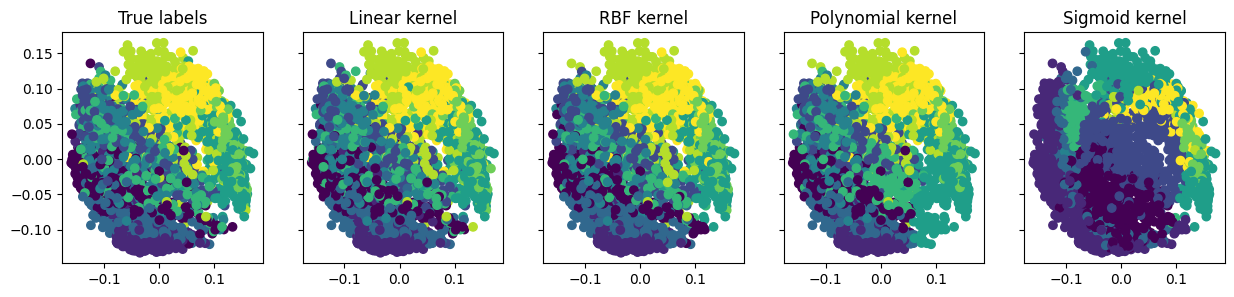

In [17]:
model = KernelPCA(n_components = 2, kernel = "sigmoid").fit_transform(x_test)

fig, axs = plt.subplots(1, 5, figsize = (15, 3), sharex=True, sharey=True)

titles = ["True labels", "Linear kernel", "RBF kernel", "Polynomial kernel", "Sigmoid kernel"]

i = 0
for ax in axs:
    ax.scatter(model[:, 0], model[:, 1], c = labels_SVC_true[:, i], cmap = 'viridis')
    ax.title.set_text(titles[i])
    i += 1



In [18]:
labels = np.hstack((labels_SVC_unsupervised, labels_SVC_true))

NameError: name 'labels_SVC_unsupervised' is not defined

#### 5.2: Fully Connected NN
Trying different numbers of layers and hidden features

In [30]:
data_train = TensorDataset(Tensor(x_train.reshape(-1, 1, 28, 28)), th.tensor(y_train.reshape(len(y_train)), dtype = th.long))
data_train_loader = DataLoader(dataset = data_train, batch_size = BATCH_SIZE, shuffle = False)

data_test = TensorDataset(Tensor(x_test.reshape(-1, 1, 28, 28)), th.tensor(y_test.reshape(len(y_test)), dtype = th.long))
data_test_loader = DataLoader(dataset = data_test, batch_size = BATCH_SIZE, shuffle = False)

In [31]:
device = th.device("cuda" if th.cuda.is_available() else "cpu")

### 5.2
Fully Connected Neural Network

In [ ]:
# Train the Fully Connected Neural Network with 2 layers and calculate accuracy on the test set for different number of epochs

if train_multiple_models:
    # Choose the loss
    criterion = nn.CrossEntropyLoss()

    # optimizer = optim.Adam(model.parameters(), lr = 0.0001, weight_decay = 0.0001)

    epochs = np.arange(1, 21, 1)

    model = FullyConnectedNN_2layer(image_dim = 28 * 28, n_classes = 10, hidden_features = 250).to(device)
    
    model = model.eval()

    untrained_loss, untrained_acc = get_test_stats(model, criterion, train_loader, device)
    print(f"Untrained test loss: {untrained_loss:.4f}, accuracy: {untrained_acc:.2f}%")

    trained_acc_FC_2l = []
    labels_FC_2l = np.ndarray((len(x_test), len(epochs)))

    for i in range(len(epochs)):
        
        model = FullyConnectedNN_2layer(image_dim = 28 * 28, n_classes = 10, hidden_features = 250).to(device)

        optimizer = th.optim.SGD(model.parameters(), lr = 0.01)
        
        model = model.train()

        model = train_model(epochs = epochs[i],
                                train_loader = data_train_loader,
                                criterion = criterion,
                                optimizer = optimizer,
                                device = device,
                                model = model)
        model = model.eval()
                
        trained_loss, trained_acc = get_test_stats(model, criterion, data_test_loader, device)
        
        trained_acc_FC_2l.append(trained_acc)

        print(f"Accuracy: {trained_acc} | Loss: {trained_loss}")
        
        labels_FC_2l[:, i] = get_predicted_labels(test_data = x_test, device = device, model = model)

In [ ]:
# Plot the accuracy wrt the number of epochs used to train the model

if train_multiple_models:
    plt.plot(epochs, trained_acc_FC_2l)
    plt.xticks(epochs[::2])
    plt.xlabel('Number of epochs')
    plt.ylabel('Accuracy')
    plt.ylim(50, 100)
    # plt.savefig("Report/ex5_FCNN2l_accuracy-epochs.png")

In [ ]:
# Train the Convolutional Neural Network with 2 layers and calculate accuracy on the test set for different number of neurons

if train_multiple_models:
    # Choose the loss
    criterion = nn.CrossEntropyLoss()

    neurons = np.arange(50, 10050, 1000)

    labels_FC_2l = np.ndarray((len(x_test), len(neurons)))
    trained_acc_FC_2l = []


    for i in range(len(neurons)):
        model = FullyConnectedNN_2layer(image_dim = 28 * 28, n_classes = 10, hidden_features = neurons[i]).to(device)
        
        optimizer = th.optim.SGD(model.parameters(), lr = 0.01)

        untrained_loss, untrained_acc = get_test_stats(model, criterion, train_loader, device)
        print(f"Untrained test loss: {untrained_loss:.4f}, accuracy: {untrained_acc:.2f}%")
        
        model = model.train()

        model = train_model(epochs = 8,
                                train_loader = data_train_loader,
                                criterion = criterion,
                                optimizer = optimizer,
                                device = device,
                                model = model)
        model = model.eval()
                
        trained_loss, trained_acc = get_test_stats(model, criterion, data_test_loader, device)
        
        trained_acc_FC_2l.append(trained_acc)

        print(f"Accuracy: {trained_acc} | Loss: {trained_loss}")
        
        labels_FC_2l[:, i] = get_predicted_labels(test_data = x_test, device = device, model = model)

    # print(f"Epochs: {epochs[i]} | Accuracy: untrained: {untrained_acc:.4f} | Trained: {trained_acc:.4f} | Time: {times[i, 1]:.2f} s")

In [ ]:
# Plot the accuracy wrt the number of neurons

if train_multiple_models:
    plt.plot(neurons, trained_acc_FC_2l)
    plt.xlabel("Number neurons per hidden layer")
    plt.ylabel("Trained accuracy")
    plt.ylim(50, 100)
    plt.savefig("Report/ex5_FCNN2l_accuracy-neurons.png")

In [ ]:
# Train the Convolutional Neural Network with 2 layers and calculate accuracy on the test set for different number of neurons

if train_multiple_models:
    # Choose the loss
    criterion = nn.CrossEntropyLoss()

    epochs = np.arange(1, 21, 1)

    labels_FC_2l = np.ndarray((len(x_test), len(epochs)))
    trained_acc_FC_2l = []


    for i in range(len(epochs)):
        model = FullyConnectedNN_2layer(image_dim = 28 * 28, n_classes = 10, hidden_features = 50).to(device)
        
        optimizer = th.optim.SGD(model.parameters(), lr = 0.01)

        untrained_loss, untrained_acc = get_test_stats(model, criterion, train_loader, device)
        print(f"Untrained test loss: {untrained_loss:.4f}, accuracy: {untrained_acc:.2f}%")
        
        model = model.train()

        model = train_model(epochs = epochs[i],
                                train_loader = data_train_loader,
                                criterion = criterion,
                                optimizer = optimizer,
                                device = device,
                                model = model)
        model = model.eval()
                
        trained_loss, trained_acc = get_test_stats(model, criterion, data_test_loader, device)
        
        trained_acc_FC_2l.append(trained_acc)

        print(f"Accuracy: {trained_acc} | Loss: {trained_loss}")
        
        labels_FC_2l[:, i] = get_predicted_labels(test_data = x_test, device = device, model = model)

    # print(f"Epochs: {epochs[i]} | Accuracy: untrained: {untrained_acc:.4f} | Trained: {trained_acc:.4f} | Time: {times[i, 1]:.2f} s")

In [ ]:
# Plot the accuracy wrt the number of neurons

if train_multiple_models:
    plt.plot(epochs, trained_acc_FC_2l)
    plt.xlabel("Number of epochs")
    plt.ylabel("Trained accuracy")
    plt.ylim(50, 100)
    plt.savefig("Report/ex5_FCNN2l_accuracy-epochs.png")

In [32]:
# Choose one model and a set of parameter to predict the labels

# Choose the loss
criterion = nn.CrossEntropyLoss()

accuracies = []
times = []

for i in range(20):
    model = FullyConnectedNN_2layer(image_dim = 28 * 28, n_classes = 10, hidden_features = 50).to(device)
    optimizer = th.optim.SGD(model.parameters(), lr = 0.01)

    untrained_loss, untrained_acc = get_test_stats(model, criterion, train_loader, device)
    print(f"Untrained test loss: {untrained_loss:.4f}, accuracy: {untrained_acc:.2f}%")

    model = model.train()

    start_time = time.time()
    model = train_model(epochs = 10,
                            train_loader = data_train_loader,
                            criterion = criterion,
                            optimizer = optimizer,
                            device = device,
                            model = model)
    elapsed_time = time.time() - start_time
    model = model.eval()
            
    trained_loss, trained_acc = get_test_stats(model, criterion, data_test_loader, device)

    print(f"Accuracy: {trained_acc} | Loss: {trained_loss} | Time: {elapsed_time}")
    accuracies.append(trained_acc)
    times.append(elapsed_time)

    # labels_FC_2l = get_predicted_labels(test_data = x_test, device = device, model = model)

Untrained test loss: 2.3948, accuracy: 1.56%


  0%|          | 0/10 [00:00<?, ?it/s]

Accuracy: 87.5 | Loss: 0.5427464246749878 | Time: 3.184083938598633
Untrained test loss: 2.3165, accuracy: 7.81%


  0%|          | 0/10 [00:00<?, ?it/s]

Accuracy: 87.5 | Loss: 0.5543144345283508 | Time: 1.6952919960021973
Untrained test loss: 2.3012, accuracy: 12.50%


  0%|          | 0/10 [00:00<?, ?it/s]

Accuracy: 87.5 | Loss: 0.5276960134506226 | Time: 1.6330912113189697
Untrained test loss: 2.2939, accuracy: 4.69%


  0%|          | 0/10 [00:00<?, ?it/s]

Accuracy: 87.5 | Loss: 0.5511186122894287 | Time: 1.6474926471710205
Untrained test loss: 2.3081, accuracy: 3.12%


  0%|          | 0/10 [00:00<?, ?it/s]

Accuracy: 87.5 | Loss: 0.5210174918174744 | Time: 1.9661588668823242
Untrained test loss: 2.2787, accuracy: 12.50%


  0%|          | 0/10 [00:00<?, ?it/s]

Accuracy: 87.5 | Loss: 0.5232203006744385 | Time: 1.644730806350708
Untrained test loss: 2.3272, accuracy: 10.94%


  0%|          | 0/10 [00:00<?, ?it/s]

Accuracy: 87.5 | Loss: 0.564734697341919 | Time: 1.8498430252075195
Untrained test loss: 2.4049, accuracy: 4.69%


  0%|          | 0/10 [00:00<?, ?it/s]

Accuracy: 89.0625 | Loss: 0.5358697175979614 | Time: 1.9499249458312988
Untrained test loss: 2.3045, accuracy: 3.12%


  0%|          | 0/10 [00:00<?, ?it/s]

Accuracy: 89.0625 | Loss: 0.5296509861946106 | Time: 2.195150136947632
Untrained test loss: 2.3372, accuracy: 17.19%


  0%|          | 0/10 [00:00<?, ?it/s]

Accuracy: 87.5 | Loss: 0.5387546420097351 | Time: 2.45015811920166
Untrained test loss: 2.3324, accuracy: 7.81%


  0%|          | 0/10 [00:00<?, ?it/s]

Accuracy: 90.625 | Loss: 0.5354480743408203 | Time: 2.8039968013763428
Untrained test loss: 2.3409, accuracy: 4.69%


  0%|          | 0/10 [00:00<?, ?it/s]

Accuracy: 89.0625 | Loss: 0.5349029302597046 | Time: 1.9655330181121826
Untrained test loss: 2.3268, accuracy: 4.69%


  0%|          | 0/10 [00:00<?, ?it/s]

Accuracy: 89.0625 | Loss: 0.5393604636192322 | Time: 1.8598570823669434
Untrained test loss: 2.3154, accuracy: 6.25%


  0%|          | 0/10 [00:00<?, ?it/s]

Accuracy: 89.0625 | Loss: 0.5233965516090393 | Time: 1.7717339992523193
Untrained test loss: 2.3130, accuracy: 12.50%


  0%|          | 0/10 [00:00<?, ?it/s]

Accuracy: 87.5 | Loss: 0.5552586317062378 | Time: 1.7394490242004395
Untrained test loss: 2.3516, accuracy: 3.12%


  0%|          | 0/10 [00:00<?, ?it/s]

Accuracy: 87.5 | Loss: 0.54291170835495 | Time: 1.8948049545288086
Untrained test loss: 2.3169, accuracy: 12.50%


  0%|          | 0/10 [00:00<?, ?it/s]

Accuracy: 89.0625 | Loss: 0.5375983715057373 | Time: 1.7256498336791992
Untrained test loss: 2.3051, accuracy: 7.81%


  0%|          | 0/10 [00:00<?, ?it/s]

Accuracy: 87.5 | Loss: 0.5455701351165771 | Time: 1.7455270290374756
Untrained test loss: 2.3179, accuracy: 10.94%


  0%|          | 0/10 [00:00<?, ?it/s]

Accuracy: 87.5 | Loss: 0.5399959683418274 | Time: 1.6751539707183838
Untrained test loss: 2.3085, accuracy: 1.56%


  0%|          | 0/10 [00:00<?, ?it/s]

Accuracy: 87.5 | Loss: 0.5553761124610901 | Time: 1.7913398742675781


In [33]:
print(f"Accuracy: Max {np.max(accuracies):.2f} | Min {np.min(accuracies):.2f} | Mean {np.mean(accuracies):.2f}")
print(f"Time: Max {np.max(times):.2f} | Min {np.min(times):.2f} | Mean {np.mean(times):.2f}")

Accuracy: Max 90.62 | Min 87.50 | Mean 88.12
Time: Max 3.18 | Min 1.63 | Mean 1.96


#### 5.3:
Convolutional and Fully Convolutional Neural Network

In [ ]:
# Train the Convolutional Neural Network with 2 layers and calculate accuracy on the test set for different number of neurons per hidden layer
if train_multiple_models:
    
    neurons = np.arange(50, 550, 100)
    
    labels_CNN_2l = np.ndarray((len(x_test), len(neurons)))
    
    trained_acc_CNN_2l = []
    
    for i in range(len(neurons)):
        model = CNN_2layer(n_classes = 10, kernel_size1 = kernel_size_CNN, kernel_size2 = kernel_size_CNN, input_size = [7000, 1, 28, 28], hidden_size = neurons[i], pool_size1 = pool_size_CNN, pool_size2 = pool_size_CNN)

        criterion = nn.CrossEntropyLoss()

        optimizer = th.optim.SGD(model.parameters(), lr = learning_rate_CNN)

        model = model.to(device)

        model = model.eval()

        untrained_loss, untrained_acc = get_test_stats(model, criterion, data_train_loader, device)


        model = model.train()

        start_time = time.time()
        model = train_model(epochs = 3,
                            train_loader = data_train_loader,
                            criterion = criterion,
                            optimizer = optimizer,
                            device = device,
                            model = model)

        model = model.eval()
        times = time.time() - start_time
        trained_loss, trained_acc = get_test_stats(model, criterion, data_test_loader, device)
        print(f"Neurons: {neurons[i]} | Accuracy: untrained: {untrained_acc:.4f} | Trained: {trained_acc:.4f} | Time: {times:.2f} s")
        
        trained_acc_CNN_2l.append(trained_acc)

        model = model.eval()
        labels_CNN_2l[:, i] = get_predicted_labels(test_data = x_test, model = model, device = device)

In [ ]:
# Plot the accuracy wrt the number of neurons per hidden layer

if train_multiple_models:
    plt.plot(neurons, trained_acc_CNN_2l)
    plt.xlabel("Number neurons per hidden layer")
    plt.ylabel("Trained accuracy")
    plt.ylim(50, 100)
    plt.savefig("Report/ex5_CNN2l_accuracy-neurons.png")

In [ ]:
# Train the Convolutional Neural Network with 2 layers and calculate accuracy on the test set for different number of neurons per hidden layer
if train_multiple_models:
    
    epochs = np.arange(1, 8, 2)
    
    labels_CNN_2l = np.ndarray((len(x_test), len(neurons)))
    
    trained_acc_CNN_2l = []
    
    for i in range(len(epochs)):
        model = CNN_2layer(n_classes = 10, kernel_size1 = kernel_size_CNN, kernel_size2 = kernel_size_CNN, input_size = [7000, 1, 28, 28], hidden_size = hidden_size_CNN, pool_size1 = kernel_size_CNN, pool_size2 = kernel_size_CNN)

        criterion = nn.CrossEntropyLoss()

        optimizer = th.optim.SGD(model.parameters(), lr = learning_rate_CNN)

        model = model.to(device)

        model = model.eval()

        untrained_loss, untrained_acc = get_test_stats(model, criterion, data_train_loader, device)


        model = model.train()

        start_time = time.time()
        model = train_model(epochs = epochs[i],
                            train_loader = data_train_loader,
                            criterion = criterion,
                            optimizer = optimizer,
                            device = device,
                            model = model)

        model = model.eval()
        times = time.time() - start_time
        trained_loss, trained_acc = get_test_stats(model, criterion, data_test_loader, device)
        print(f"Epoch: {epochs[i]} | Accuracy: untrained: {untrained_acc:.4f} | Trained: {trained_acc:.4f} | Time: {times:.2f} s")
        
        trained_acc_CNN_2l.append(trained_acc)

        model = model.eval()
        labels_CNN_2l[:, i] = get_predicted_labels(test_data = x_test, model = model, device = device)

In [ ]:
if train_multiple_models:
    plt.plot(epochs, trained_acc_CNN_2l)
    plt.xlabel("Number of epochs")
    plt.ylabel("Trained accuracy")
    plt.ylim(50, 100)
    plt.savefig("Report/ex5_CNN2l_accuracy-epochs.png")

In [40]:
# Choose one set of parameters
accuracies = []
times = []

for i in range(10):
    model = CNN_2layer(n_classes = 10, kernel_size1 = kernel_size_CNN, kernel_size2 = kernel_size_CNN, input_size = [7000, 1, 28, 28], hidden_size = hidden_size_CNN, pool_size1 = pool_size_CNN, pool_size2 = pool_size_CNN)

    criterion = nn.CrossEntropyLoss()

    optimizer = th.optim.SGD(model.parameters(), lr = learning_rate_CNN)


    model = model.to(device)

    model = model.eval()

    untrained_loss, untrained_acc = get_test_stats(model, criterion, train_loader, device)

    print(f"Untrained test loss: {untrained_loss:.4f}, accuracy: {untrained_acc:.2f}%")

    model = model.train()

    start_time = time.time()
    model = train_model(epochs = epochs_CNN,
                        train_loader = data_train_loader,
                        criterion = criterion,
                        optimizer = optimizer,
                        device = device,
                        model = model)
    elapsed_time = time.time() - start_time

    model = model.eval()
    trained_loss, trained_acc = get_test_stats(model, criterion, data_test_loader, device)
    print(f"Accuracy: {trained_acc} | Loss: {trained_loss} | Elapsed time: {elapsed_time:.2f} s")

    accuracies.append(trained_acc)
    times.append(elapsed_time)
    # model = model.eval()
    # labels_CNN_2l = get_predicted_labels(test_data = x_test, model = model, device = device)

Untrained test loss: 2.2999, accuracy: 15.62%


  0%|          | 0/3 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
print(f"Accuracy: Max {np.max(accuracies):.2f} | Min {np.min(accuracies):.2f} | Mean {np.mean(accuracies):.2f}")
print(f"Time: Max {np.max(times):.2f} | Min {np.min(times):.2f} | Mean {np.mean(times):.2f}")